# Basic image analysis

gPhoton2 images are standard FITS files with multiple extensions.

They can be displayed and processed with standard tools for working with FITS image data.

We recommending using the [planetary data read](https://github.com/MillionConcepts/pdr/) for opening gPhoton2 images. However, any standard FITS-capable software, including `astropy` or `ds9` will work just fine.


In [83]:
from rich import print # purely for aesthetics

import pdr
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np
import warnings

import warnings
warnings.filterwarnings('ignore')

In [81]:
image_fd = pdr.read('../test_data/e23456/e23456-fd-ffull-b00-image-r.fits')
image_nd = pdr.read('../test_data/e23456/e23456-nd-ffull-b00-image-r.fits')

# By default, `pdr` "lazy loads" data. The `.load_all()` method loads all data into memory.
image_fd.load_all()
image_nd.load_all()

print(f'The valid keys are {image_fd.keys()}.')
print(f'The valid keys are {image_nd.keys()}.')

The valid keys are ['PRIMARY', 'CNT', 'FLAG', 'COVERAGE', 'DOSE', 'PRIMARY_HEADER', 'CNT_HEADER', 'FLAG_HEADER', 
'COVERAGE_HEADER', 'DOSE_HEADER'].

The valid keys are ['PRIMARY', 'CNT', 'FLAG', 'COVERAGE', 'DOSE', 'PRIMARY_HEADER', 'CNT_HEADER', 'FLAG_HEADER', 
'COVERAGE_HEADER', 'DOSE_HEADER'].

In [77]:
image_fd.load_all()
image_fd.keys()

['PRIMARY',
 'CNT',
 'FLAG',
 'COVERAGE',
 'DOSE',
 'PRIMARY_HEADER',
 'CNT_HEADER',
 'FLAG_HEADER',
 'COVERAGE_HEADER',
 'DOSE_HEADER']

# Display / review the image HDU backplanes

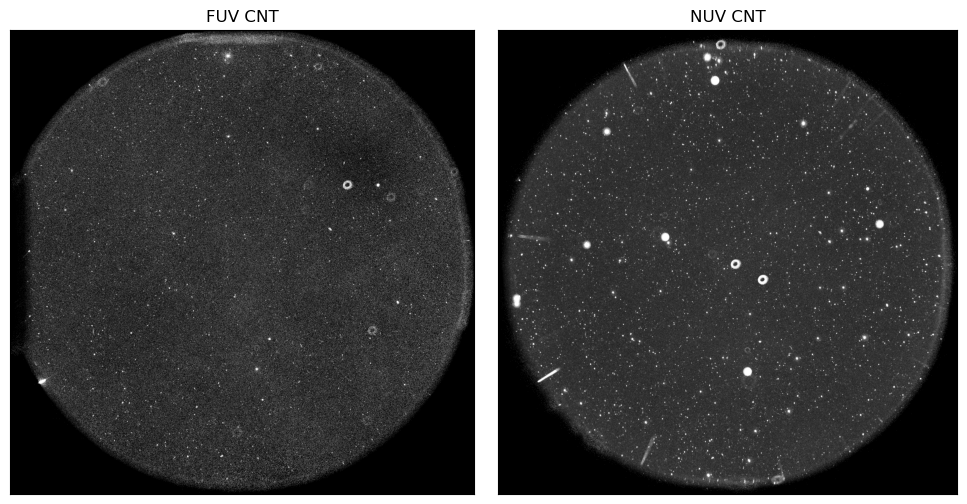

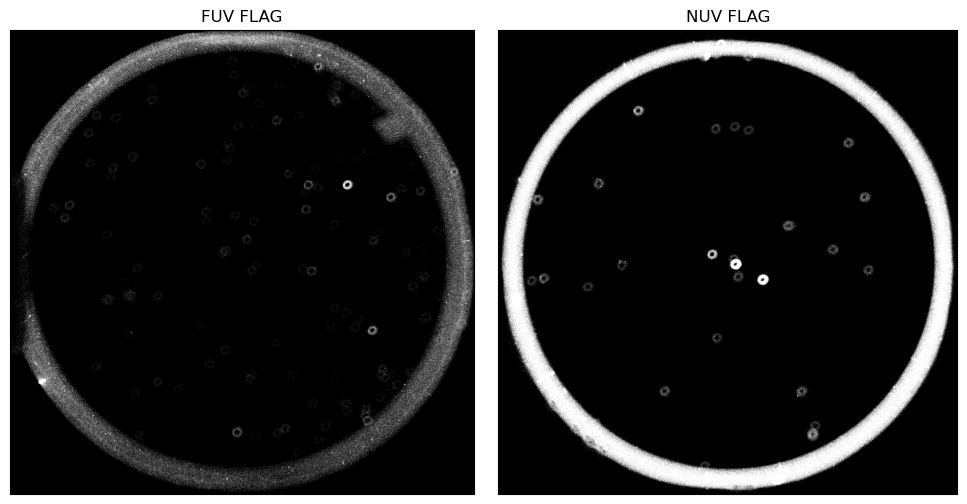

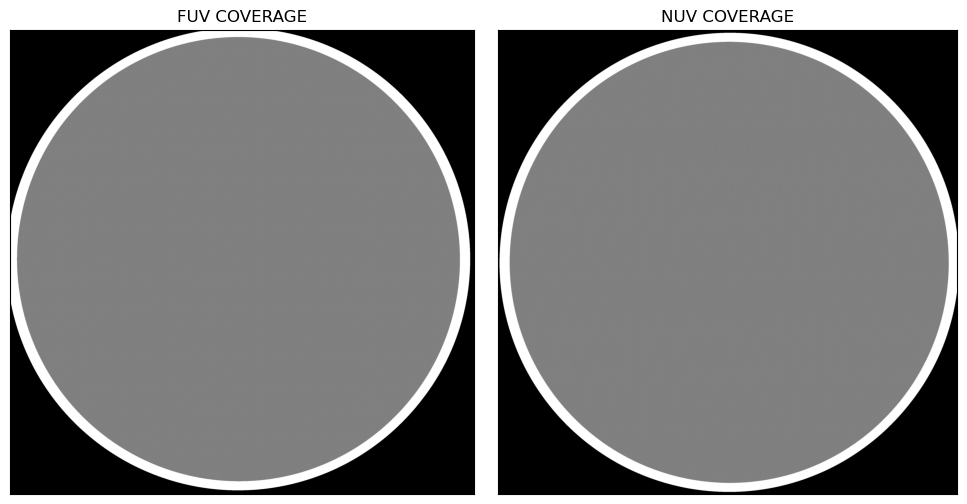

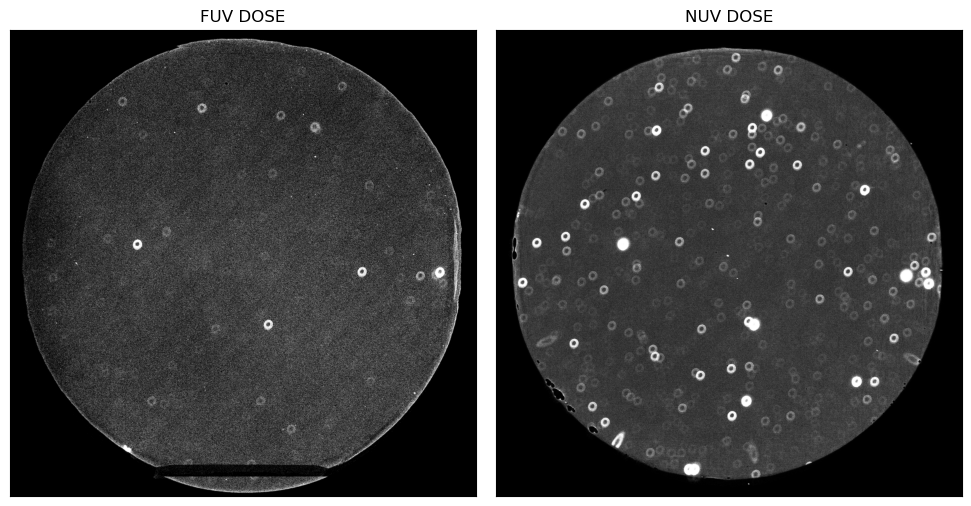

In [3]:
for k in ['CNT', 'FLAG', 'COVERAGE', 'DOSE']:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(ZScaleInterval()(image_fd[k]), cmap="binary_r", origin="lower")
    axes[0].set_title(f'FUV {k}')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    axes[1].imshow(ZScaleInterval()(image_nd[k]), cmap="binary_r", origin="lower")
    axes[1].set_title(f'NUV {k}')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.savefig(f'figures/{k.lower()}_image_example_e23456.png', dpi=300, bbox_inches='tight')
plt.show()


---

# Apply coverage mask and scale by effective exposure time

The `COVERAGE` extension contains a mask indicating which pixels were covered by the 1.25 degree FOV during the observation. Pixels with a value of 0 were not covered, and should be ignored in any analysis. Pixels with a value greater than 2 were _partially_ covered. Pixels with a value of 1 were fully covered. The effective exposure time given by `XPOSURE` in the count image header is the exposure time for fully covered pixels. Therefore, to get an accurate count rate image, you should mask out pixels with `COVERAGE` values of 0 or greater than 1, and scale the remaining pixels by the effective exposure time.

Note: `XPOSURE` is the FITS standard keyword for effective exposure time of an image, corrected for dead time etc. effects. However, there is no FITS standard for effective exposure time of a series of image frames stored as an MxNxF array, which is is how gPhoton2 stores movie data. gPhoton2 uses ['EXPT_0', 'EXPT_1', ...] keywords to store the effective exposure time for each frame in a movie. For consistency, _image_ files are treated like "movies with a single frame," and therefore use the 'EXPT_0' keyword for effective exposure time. For an `-image` file, `XPOSURE` and `EXPT_0` will have the same value.

In [ ]:
# The effective exposure time is stored in the header of the FITS file, under the key 'XPOSURE'.
fd_expt = image_fd['CNT_HEADER']['XPOSURE'] # or image_fd['CNT_HEADER']['EXPT_0']
nd_expt = image_nd['CNT_HEADER']['XPOSURE'] # or image_nd['CNT_HEADER']['EXPT_0']

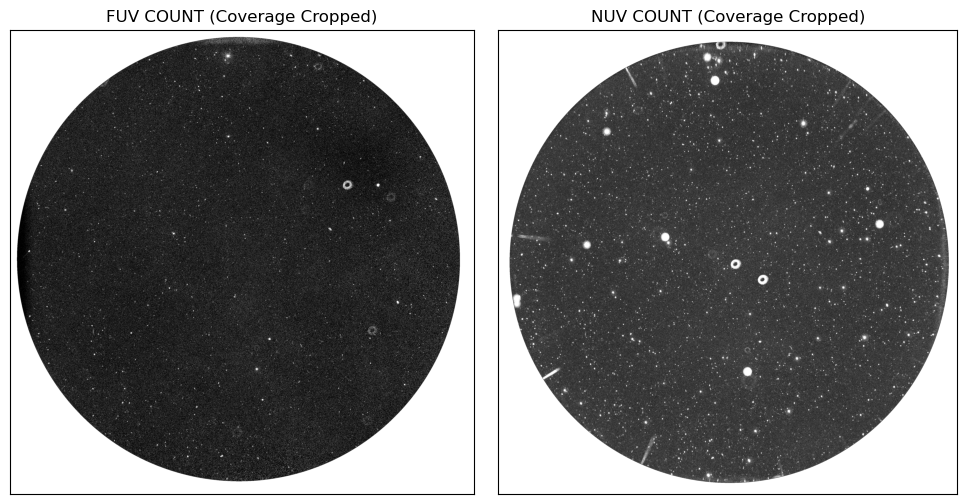

In [9]:
# Crop the image to the regionof full exposure coverage and then divide by the exposure time.
cnt_fd_cropped = np.where(image_fd['COVERAGE'] == 1, image_fd['CNT'], np.nan)
cnt_nd_cropped = np.where(image_nd['COVERAGE'] == 1, image_nd['CNT'], np.nan)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# FUV
axes[0].imshow(ZScaleInterval()(cnt_fd_cropped/fd_expt), cmap="binary_r", origin="lower")
axes[0].set_title('FUV COUNT (Coverage Cropped)')
axes[0].set_xticks([])
axes[0].set_yticks([])

# NUV
axes[1].imshow(ZScaleInterval()(cnt_nd_cropped/nd_expt), cmap="binary_r", origin="lower")
axes[1].set_title('NUV COUNT (Coverage Cropped)')
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.savefig(f'figures/count_cropped_example_e23456.png', dpi=300, bbox_inches='tight')
plt.show()


## Display with galactic coordinates

For many applications, it is preferable to display to display images in galactic coordinates. This can be done by using the `WCS` class from `astropy.wcs` to create a WCS object, and then using `WCSAxes` to display the image.

In [71]:
image_fd['CNT_HEADER']

<MultiDict('XTENSION': 'IMAGE', 'BITPIX': -32, 'BITPIX_comment': 'data type of original image', 'NAXIS': 2, 'NAXIS_comment': 'dimension of original image', 'NAXIS1': 3078, 'NAXIS1_comment': 'length of original image axis', 'NAXIS2': 3077, 'NAXIS2_comment': 'length of original image axis', 'PCOUNT': 0, 'GCOUNT': 1, 'EXTNAME': 'CNT', 'TELESCOP': 'GALEX', 'ECLIPSE': 23456, 'LEG': 0, 'BANDNAME': 'FUV', 'BAND': 2, 'TIMESYS': 'UTC', 'TIMEUNIT': 's', 'DATE-BEG': '2007-09-20T22:07:21', 'DATE-END': '2007-09-20T22:35:46', 'TSTART': 874361241.995, 'TSTOP': 874362946.995, 'TELAPSE': 1705.0, 'XPOSURE': 1677.152, 'T0_0': 874361241.995, 'T1_0': 874362946.995, 'EXPT_0': 1677.152, 'PHOTCNT': 3883712, 'N_FRAME': 1, 'CDELT1': -0.000416666666666667, 'CDELT2': 0.000416666666666667, 'CTYPE1': 'RA---TAN', 'CTYPE2': 'DEC--TAN', 'CRPIX1': 1539.5, 'CRPIX2': 1539.0, 'CRVAL1': 323.476868689636, 'CRVAL2': -2.0728021445896, 'EQUINOX': 2000.0, 'EPOCH': 2000.0, 'ORIGIN': 'Million Concepts', 'VERSION': 'v3.0.0a0', 'DA

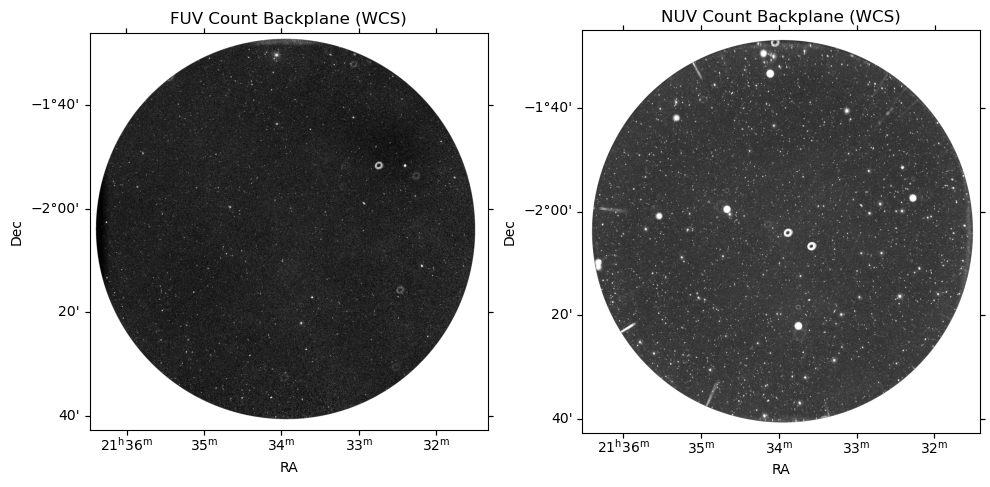

In [84]:
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs import WCS

wcs_fd = WCS(image_fd['CNT_HEADER'])
wcs_nd = WCS(image_nd['CNT_HEADER'])

fig = plt.figure(figsize=(10, 5))

# FUV image with WCS
ax_fuv = fig.add_subplot(1, 2, 1, projection=wcs_fd)
ax_fuv.imshow(ZScaleInterval()(cnt_fd_cropped/fd_expt), cmap="binary_r", origin="lower")
ax_fuv.set_title('FUV Count Backplane (WCS)')
ax_fuv.set_xlabel('RA')
ax_fuv.set_ylabel('Dec')

# NUV image with WCS
ax_nuv = fig.add_subplot(1, 2, 2, projection=wcs_nd)
ax_nuv.imshow(ZScaleInterval()(cnt_nd_cropped/nd_expt), cmap="binary_r", origin="lower")
ax_nuv.set_title('NUV Count Backplane (WCS)')
ax_nuv.set_xlabel('RA')
ax_nuv.set_ylabel('Dec')

plt.tight_layout()
plt.savefig(f'figures/count_cropped_example_e23456_wcs.png', dpi=300, bbox_inches='tight')
plt.show()


---

# Working with movies

It can be useful to display movies as animations. Here is one example of how to do that, by first creating a GIF.

In [24]:
movie_fd = pdr.read('../test_data/e23456/e23456-fd-f0120-b00-movie-r.fits')
movie_nd = pdr.read('../test_data/e23456/e23456-nd-f0120-b00-movie-r.fits')
print(f'The valid keys are {movie_fd.keys()}.')

The valid keys are ['PRIMARY', 'CNT', 'FLAG', 'EDGE'].


In [85]:
# Although it doesn't change the data visualization in this case, let's
# give an example of how to extract and scale exposure time for movies.
nframes_fd = movie_fd['CNT_HEADER']['NAXIS3']
nframes_nd = movie_nd['CNT_HEADER']['NAXIS3']

# Note that in this example, the number of frames in the FUV and NUV movies is the same.
# That is not always the case. They also do not necessarily align in time.
#       (Although one may force them to align so with gPhoton2 keywords.)
print(f'Number of frames in FUV movie: {nframes_fd}')
print(f'Number of frames in NUV movie: {nframes_nd}')

# The effective exposure times are stored in the `EXPT_N` keywords where N is the frame index.
expt_fd = [movie_fd['CNT_HEADER'][f'EXPT_{i}'] for i in range(nframes_fd)]
expt_nd = [movie_nd['CNT_HEADER'][f'EXPT_{i}'] for i in range(nframes_nd)]
print(f'FUV effective exposure times: {expt_fd}')
print(f'NUV effective exposure times: {expt_nd}')

Number of frames in FUV movie: 15

Number of frames in NUV movie: 15

FUV effective exposure times: [116.541753265032, 118.555894176537, 118.587641699492, 118.609398593592, 
114.667524611406, 118.629518907163, 118.630305107613, 118.633054135039, 118.630823892945, 118.622175687989, 
118.619432008865, 118.610206187252, 118.596733813545, 118.558568327729, 23.7014798216006]

NUV effective exposure times: [103.73992108944, 105.745945110233, 105.918524861058, 106.049336191078, 
102.6026672146, 106.204727777903, 106.241074579995, 106.246439899449, 106.234966110313, 106.206394235992, 
106.137438902655, 106.083903936562, 105.953188315284, 105.752565903179, 21.1115827475404]

In [52]:
from IPython.display import Image, display
import imageio

masked_frames = []
cmap = plt.get_cmap("binary_r").copy()
cmap.set_bad(color='yellow')  # Masked pixels will appear red

for i in range(n_frames):
    cnt_fd_masked = np.ma.masked_where(movie_fd['FLAG'][i] != 0, movie_fd['CNT'][i], copy=True)
    cnt_nd_masked = np.ma.masked_where(movie_nd['FLAG'][i] != 0, movie_nd['CNT'][i], copy=True)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(ZScaleInterval()(cnt_fd_masked)/expt_fd[i], cmap=cmap, origin="lower")
    axes[0].set_title(f'FUV Frame {i}')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].imshow(ZScaleInterval()(cnt_nd_masked)/expt_nd[i], cmap=cmap, origin="lower")
    axes[1].set_title(f'NUV Frame {i}')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    plt.tight_layout()
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frame = frame[..., :3]
    masked_frames.append(frame)
    plt.close(fig)

imageio.mimsave('figures/count_movie_example_e23456.gif', masked_frames, duration=0.5, loop=0)


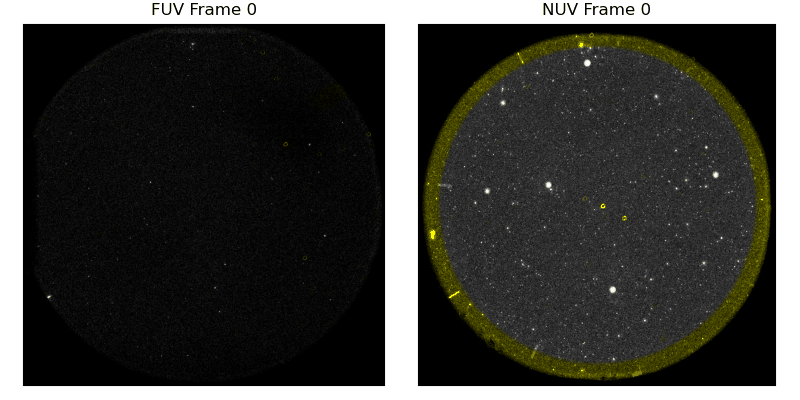

In [53]:
from IPython.display import Image

display(Image(filename='figures/count_movie_example_e23456.gif'))
